# Couple Candlesticks - Strategy - Backtesting 

### Import Library

In [17]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [18]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [19]:
data = dataset.copy()

In [20]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [21]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-11-06 14:15:00,1339.7,1339.9,1338.1,1338.9,8052
2024-11-06 14:20:00,1338.9,1339.4,1338.1,1339.1,4755
2024-11-06 14:25:00,1339.2,1340.3,1339.0,1339.3,7570


In [22]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond

def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] == r['Low'] and r['Low'] < r['prev_low']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] == r['High']  and r['High'] > r['prev_high']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond

def get_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [23]:
def prepare_data(data):
    data['prev_low'] = data['Low'].shift(1)
    data['prev_high'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    return data

In [24]:
class BacktestingTemmplate(Strategy):
    max_range = 7
    max_sl = 3
    def init(self):
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return

        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        signal = self.data.signal[-1]
        if signal == 'long':
            if self.position.is_short:
                self.position.close()
            buy_price = close_price
            min_5 = self.data.min_5[-1]
            tmp_risk = buy_price - min_5
            risk = min(tmp_risk, self.max_sl)
            sl = buy_price - risk
            tp = buy_price + (self.max_range - risk)
            self.buy(size=1, sl=sl, tp=tp, limit=buy_price)
        elif signal == 'short':
            if self.position.is_long:
                self.position.close()
            sell_price = close_price
            max_5 = self.data.max_5[-1]
            tmp_risk = max_5 - sell_price
            risk = min(tmp_risk, self.max_sl)
            sl = sell_price + risk
            tp = sell_price - (self.max_range - risk)
            self.sell(size=1, sl=sl, tp=tp, limit=sell_price)

In [25]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [26]:
# prepared_data[(prepared_data.index > '2024-11-05 00:00:00') & (prepared_data.index < '2024-11-05 15:00:00')]

In [27]:
bt = Backtest(prepared_data, BacktestingTemmplate, commission=.0003, exclusive_orders=False)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-02 09:20:00
End                       2024-11-06 14:45:00
Duration                   1465 days 05:25:00
Exposure Time [%]                   26.783514
Equity Final [$]                   9179.97862
Equity Peak [$]                    10069.7084
Return [%]                          -8.200214
Buy & Hold Return [%]               49.298597
Return (Ann.) [%]                   -2.115064
Volatility (Ann.) [%]                  0.8475
Sharpe Ratio                         -2.49565
Sortino Ratio                       -3.147025
Calmar Ratio                         -0.23846
Max. Drawdown [%]                   -8.869683
Avg. Drawdown [%]                   -0.431231
Max. Drawdown Duration     1380 days 05:20:00
Avg. Drawdown Duration       63 days 09:40:00
# Trades                                 2184
Win Rate [%]                        37.225275
Best Trade [%]                       1.823504
Worst Trade [%]                     -2.110815
Avg. Trade [%]                    

In [28]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,10,11,899.63003,901.4,-1.76997,-0.001967,2020-11-02 10:10:00,2020-11-02 10:15:00,None,0 days 00:05:00
1,1,45,46,906.97201,904.0,-2.97201,-0.003277,2020-11-02 14:30:00,2020-11-02 14:45:00,None,0 days 00:15:00
2,-1,52,65,907.92754,909.4,-1.47246,-0.001622,2020-11-03 09:25:00,2020-11-03 10:30:00,None,0 days 01:05:00
3,-1,106,111,907.02781,908.8,-1.77219,-0.001954,2020-11-04 09:40:00,2020-11-04 10:05:00,None,0 days 00:25:00
4,1,123,126,914.27420,912.3,-1.97420,-0.002159,2020-11-04 11:05:00,2020-11-04 11:20:00,None,0 days 00:15:00
...,...,...,...,...,...,...,...,...,...,...,...
2179,-1,50986,50987,1322.70307,1324.4,-1.69693,-0.001283,2024-11-04 10:30:00,2024-11-04 10:35:00,None,0 days 00:05:00
2180,1,51003,51005,1322.89675,1319.5,-3.39675,-0.002568,2024-11-04 13:20:00,2024-11-04 13:30:00,None,0 days 00:10:00
2181,1,51050,51063,1319.29567,1320.0,0.70433,0.000534,2024-11-05 13:00:00,2024-11-05 14:05:00,None,0 days 01:05:00
2182,-1,51063,51068,1319.60400,1320.2,-0.59600,-0.000452,2024-11-05 14:05:00,2024-11-05 14:30:00,None,0 days 00:25:00


In [29]:
max_sl_params = [x / 10.0 for x in range(20, 50, 2)]
optimize_stats, heatmap = bt.optimize(max_range=range(5, 15, 1),
                                      max_sl=max_sl_params,
                    maximize='Return [%]', max_tries=400,
                    random_state=0,
                    return_heatmap=True)

In [30]:
optimize_stats

Start                     2020-11-02 09:20:00
End                       2024-11-06 14:45:00
Duration                   1465 days 05:25:00
Exposure Time [%]                   34.662859
Equity Final [$]                   9756.71348
Equity Peak [$]                   10140.57249
Return [%]                          -2.432865
Buy & Hold Return [%]               49.298597
Return (Ann.) [%]                   -0.605052
Volatility (Ann.) [%]                 1.21464
Sharpe Ratio                        -0.498133
Sortino Ratio                       -0.820326
Calmar Ratio                        -0.156328
Max. Drawdown [%]                   -3.870397
Avg. Drawdown [%]                    -0.23967
Max. Drawdown Duration      490 days 00:50:00
Avg. Drawdown Duration       33 days 20:05:00
# Trades                                 2159
Win Rate [%]                        31.542381
Best Trade [%]                       1.823504
Worst Trade [%]                     -2.110815
Avg. Trade [%]                    

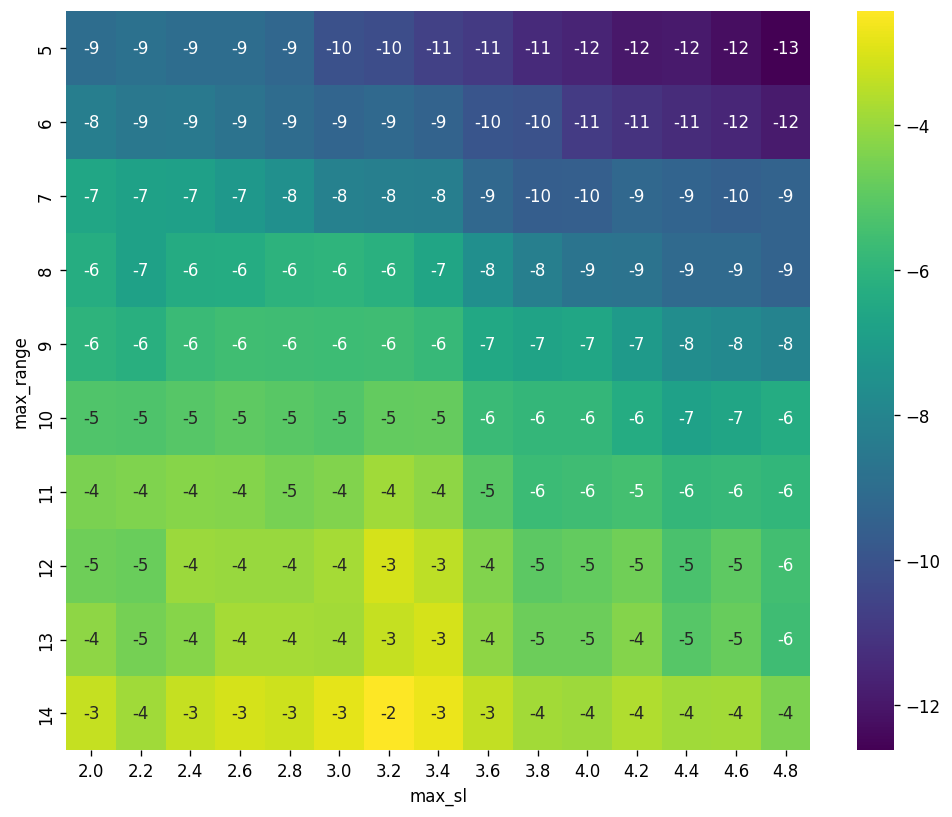

In [31]:
import seaborn as sns
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()